# Pick and Place in PyBullet

This tutorial shows how to attach a two fingered jaw gripper to the Kuka robot
to pick-and-place objects.

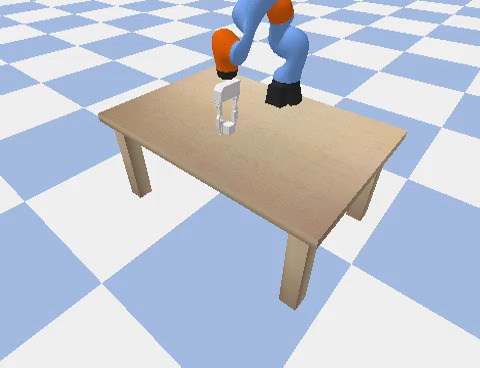

In [205]:
!pip install pybullet imageio-ffmpeg

import os
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data
import cv2
import imageio_ffmpeg
from base64 import b64encode
from IPython.display import HTML


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [206]:
p.connect(p.DIRECT) #or p.GUI for graphical version
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0,0,-10)

plane_id = p.loadURDF("plane.urdf")
kuka_id = p.loadURDF("kuka_iiwa/model_vr_limits.urdf", 1.400000, -0.200000, 0.600000, 0.000000, 0.000000, 0.000000, 1.000000)
kuka_gripper_id = p.loadSDF("gripper/wsg50_one_motor_gripper_new_free_base.sdf")[0]
table_id = p.loadURDF("table/table.urdf", basePosition=[1.0, -0.2, 0.0], baseOrientation=[0, 0, 0.7071, 0.7071])
# cube_id = p.loadURDF("cube.urdf", basePosition=[0.85, -0.2, 0.65], globalScaling=0.05)
# cube_id1 = p.loadURDF("cube.urdf", basePosition=[0.85, -0.1, 0.65], globalScaling=0.1)

# Number of cubes you want to generate
num_cubes = 5

# Initial position for the first cube
start_position = [0.85, -0.2, 0.65]

# Uniform scaling factor for all cubes
scaling_factor = 0.05

# Create the cubes in a row
cube_ids = []
for i in range(num_cubes):
    position = [start_position[0], start_position[1] + i * 0.1, start_position[2]]  # Update y position
    cube_id = p.loadURDF("cube.urdf", basePosition=position, globalScaling=scaling_factor)
    cube_ids.append(cube_id)

# attach gripper to kuka arm
kuka_cid = p.createConstraint(kuka_id, 6, kuka_gripper_id, 0, p.JOINT_FIXED, [0, 0, 0], [0, 0, 0.05], [0, 0, 0])
kuka_cid2 = p.createConstraint(kuka_gripper_id, 4, kuka_gripper_id, 6, jointType=p.JOINT_GEAR, jointAxis=[1,1,1], parentFramePosition=[0,0,0], childFramePosition=[0,0,0])
p.changeConstraint(kuka_cid2, gearRatio=-1, erp=0.5, relativePositionTarget=0, maxForce=100)

# reset kuka
jointPositions = [-0.000000, -0.000000, 0.000000, 1.570793, 0.000000, -1.036725, 0.000001]
for jointIndex in range(p.getNumJoints(kuka_id)):
    p.resetJointState(kuka_id, jointIndex, jointPositions[jointIndex])
    p.setJointMotorControl2(kuka_id, jointIndex, p.POSITION_CONTROL, jointPositions[jointIndex], 0)

# reset gripper
p.resetBasePositionAndOrientation(kuka_gripper_id, [0.923103, -0.200000, 1.250036], [-0.000000, 0.964531, -0.000002, -0.263970])
jointPositions = [0.000000, -0.011130, -0.206421, 0.205143, -0.009999, 0.000000, -0.010055, 0.000000]
for jointIndex in range(p.getNumJoints(kuka_gripper_id)):
    p.resetJointState(kuka_gripper_id, jointIndex, jointPositions[jointIndex])
    p.setJointMotorControl2(kuka_gripper_id, jointIndex, p.POSITION_CONTROL, jointPositions[jointIndex], 0)

num_joints = p.getNumJoints(kuka_id)
kuka_end_effector_idx = 6

# camera parameters
cam_target_pos = [.95, -0.2, 0.2]
cam_distance = 2.05
cam_yaw, cam_pitch, cam_roll = -50, -40, 0
cam_width, cam_height = 480, 360
cam_up, cam_up_axis_idx, cam_near_plane, cam_far_plane, cam_fov = [0, 0, 1], 2, 0.01, 100, 60

cam_target_pos_2 = [.95, -0.2, 0.2]

#video = cv2.VideoWriter('vid.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (cam_width, cam_height)) # Does not seem to support h264!
vid = imageio_ffmpeg.write_frames('vid.mp4', (cam_width, cam_height), fps=30)
vid.send(None) # seed the video writer with a blank frame

vid_2 = imageio_ffmpeg.write_frames('vid_2.mp4', (cam_width, cam_height), fps=30)
vid_2.send(None) # seed the video writer with a blank frame


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (480, 360) to (480, 368) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (480, 360) to (480, 368) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [ ]:
# robot API
def get_joint_positions(robot_id):
    return [p.getJointState(robot_id, i)[0] for i in range(num_joints)]

def go_to_position(robot_id, position, duration=1.0):
    target_orn = p.getQuaternionFromEuler([0, 1.01*math.pi, 0])
    joint_poses = p.calculateInverseKinematics(kuka_id, kuka_end_effector_idx, position, target_orn)
    for i in range(num_joints):
        p.setJointMotorControl2(robot_id, i, p.POSITION_CONTROL, joint_poses[i], force=5.0)
    time.sleep(duration)

In [207]:
def routine(task, object):
    
    # if task == 'go to':
    #     # go to the object
    #     target_pos, gripper_val = get_cube_postion(cube_ids[object]), 0
    #     # 10 cm above the object
    #     if np.linalg.norm(np.array(target_pos) - np.array(get_cube_postion(cube_ids[0]))) < 0.01:
    #         task = 'pick up'
    # elif task == 'pick up':
    #     # close the gripper
    #     target_pos, gripper_val = get_cube_postion(cube_ids[object]), 1
    #     if gripper_val > 0.9:
    #         task = 'move up'
    # elif task == 'move up':
    #     # move up after picking object
    #     target_pos, gripper_val = [0.85, -0.2, 0.97 + 0.5], 1
    #     if np.linalg.norm(np.array(target_pos) - np.array([0.85, -0.2, 0.97 + 0.5])) < 0.01:
    #         task = 'move to'
    # elif task == 'move to':
    #     # move to target position
    #     target_pos, gripper_val = get_cube_postion(cube_ids[2]), 0
    #     if np.linalg.norm(np.array(target_pos) - np.array([0.85, -0.2 + 0.4, 1.1])) < 0.01:
    #         task = 'go to'
    #         object = object + 1

    if task == 'random_move':
        # move to target position
        target_pos, gripper_val = object, 0
        if np.linalg.norm(np.array(target_pos) - object) < 0.01:
            task = 'random_move'
            object = [0.85, -0.2, 0.65]
    return task, object, target_pos, gripper_val

def get_cube_postion(cube_id):
    return p.getBasePositionAndOrientation(cube_id)[0]

def prepare_array_for_cv2(array):
    # Check if the array is in RGB format and convert to BGR
    if array.ndim == 3 and array.shape[2] == 3:
        array = cv2.cvtColor(array, cv2.COLOR_RGB2BGR)

    # Ensure the datatype is uint8
    if array.dtype != np.uint8:
        # Normalize the array if it's not in the 0-255 range
        if array.max() > 1:
            array = (array / 255).astype(np.uint8)
        else:
            array = (array * 255).astype(np.uint8)
    
    return array

timestep 749...

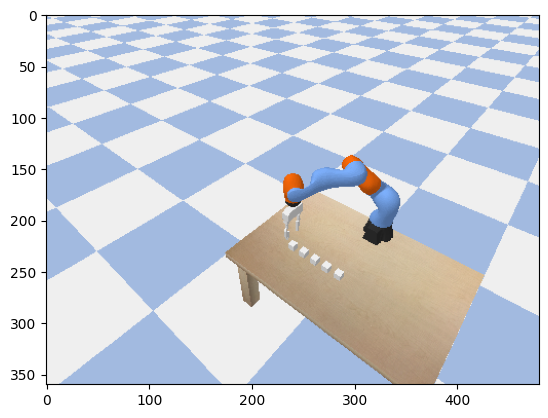

In [208]:

task = 'random_move'
object = 0

object = [0.85, -0.2, 0.65]

for t in range(750):
    print(f'\rtimestep {t}...', end='')

    if t % 4 == 0: # PyBullet default simulation time step is 240fps, but we want to record video at 60fps.
        cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll, cam_up_axis_idx)
        cam_projection_matrix = p.computeProjectionMatrixFOV(cam_fov, cam_width*1./cam_height, cam_near_plane, cam_far_plane)
        image = p.getCameraImage(cam_width, cam_height, cam_view_matrix, cam_projection_matrix)[2][:, :, :3]
        # video.write(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        # add text to the image
        image = prepare_array_for_cv2(image)
        cv2.putText(image, f'Task: {target_pos}, Gripper:{gripper_val}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0, 0, 0), 1, cv2.LINE_AA)
        # get robot coordinates
        linkState = p.getLinkState(kuka_id, kuka_end_effector_idx)
        # convert tuple to array 
        linkState = np.array(linkState[4])
        # convert to 2dp 
        linkState = np.round(linkState, 2)
        cv2.putText(image, f'Robot: {linkState}', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0, 0, 0), 1, cv2.LINE_AA)
        vid.send(np.ascontiguousarray(image))

        linkState = p.getLinkState(kuka_id, kuka_end_effector_idx)
        linkPos, linkOrn = linkState[4], linkState[5]  # World link frame position and orientation
        cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(linkPos, cam_distance, cam_yaw, cam_pitch, cam_roll, cam_up_axis_idx)
        cam_projection_matrix = p.computeProjectionMatrixFOV(cam_fov, cam_width*1./cam_height, cam_near_plane, cam_far_plane)
        image = p.getCameraImage(cam_width, cam_height, cam_view_matrix, cam_projection_matrix)[2][:, :, :3]
        #video.write(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        vid_2.send(np.ascontiguousarray(image))



    target_pos, gripper_val = [0.85, -0.5, 0.97], 0
    if t >= 150 and t < 250:
        target_pos, gripper_val = [0.85, -0.5, 0.97], 1 # grab object
    elif t >= 250 and t < 400:
        target_pos, gripper_val = [0.85, -0.5, 0.97], 1 # move up after picking object
    elif t >= 400 and t < 600:
        target_pos, gripper_val = [0.85, -0.2 + 0.4*(t-400)/200 , 1.1], 1 # move to target position
    elif t >= 600 and t < 700:
        target_pos, gripper_val = [0.85, 0.2, 1.1], 1 # stop at target position
    elif t >= 700:
        target_pos, gripper_val = [0.85, 0.2, 1.1], 0 # drop object
  



    target_orn = p.getQuaternionFromEuler([0, 1.01*math.pi, 0])
    joint_poses = p.calculateInverseKinematics(kuka_id, kuka_end_effector_idx, target_pos, target_orn)
    for j in range (num_joints):
        p.setJointMotorControl2(bodyIndex=kuka_id, jointIndex=j, controlMode=p.POSITION_CONTROL, targetPosition=joint_poses[j], targetVelocity=0.001)

    p.setJointMotorControl2(kuka_gripper_id, 4, p.POSITION_CONTROL, targetPosition=gripper_val*0.05, force=300)
    p.setJointMotorControl2(kuka_gripper_id, 6, p.POSITION_CONTROL, targetPosition=gripper_val*0.05, force=300)

    p.stepSimulation()

plt.imshow(Image.fromarray(image)) # show the last frame

vid.close()
vid_2.close()
#video.release()
p.disconnect()

In [210]:
# Play recorded video

#os.system(f"ffmpeg -y -i vid.avi -vcodec libx264 vidc.mp4") # convert to mp4 to show in browser
mp4 = open('vid.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)